In [1]:
# Run python sript if enter_parameters is needed.
# Run ipython or notebook with enter_parameters disabled if cell outputs need to be saved.
run_from_ipython = 'get_ipython' in globals()
# Use ipython display when running notebook. Print directly to console when running sript.
display = display if run_from_ipython else print

In [2]:
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from utils import *
from process import *
from analysis import *
from plots import *

if run_from_ipython:
    %matplotlib inline

with open('config.json') as f:
    config = json.load(f)

In [3]:
# Cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(config['cache_dir'], "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# Whether to manually enter parameters for analysis
enter_parameters = config['enter_parameters']
whether_redo = redo_condition(enter_parameters)

## Get session and probe

In [4]:
session_id = config['analysis_object']['session_id']
ecephys_structure_acronym = config['analysis_object']['ecephys_structure_acronym']
session = cache.get_session_data(session_id)

In [5]:
output_dir = config['output_dir']
session_dir = os.path.join(output_dir, f'session_{session_id:d}')
info_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}.json')
with open(info_file) as f:
    info = json.load(f)
print(json.dumps(info, indent=4))

probe_id = info['probe_id']
probe_dir = os.path.join(session_dir, f'probe_{probe_id:d}')
preprocess_dict = info['parameters']
parameters_dict = info['movies_pop_parameters'] = info.get('movies_pop_parameters', {})
fig_disp = figure_display_function(config)

{
    "session_id": 789848216,
    "ecephys_structure_acronym": "VISp",
    "probe_id": 805002031,
    "center_channel_id": 849914246,
    "center_unit_channel_id": 849914262,
    "fs": 1249.999853645725,
    "parameters": {},
    "has_ccf": true,
    "unit_has_ccf": true,
    "channel_group_by_ccf": true,
    "n_channel_groups": 4
}


## Load selected units in area of interest

In [6]:
units_file = os.path.join(output_dir, f'session_{session_id:d}_{ecephys_structure_acronym:s}_units.csv')
sel_units = pd.read_csv(units_file, index_col='unit_id')
sel_units_id = sel_units.index
print(f'Number of units in {ecephys_structure_acronym:s}: {len(sel_units):d}')

optotag_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_optotag_units.csv')
optotag_df = pd.read_csv(optotag_file, index_col='unit_id')

Number of units in VISp: 14


### Save data settings

In [7]:
filepath_prefix = lambda stimulus_name: os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_{stimulus_name:s}')

## Analyze spike entrainment to LFP

### Select stimuli

In [8]:
session_type = session.session_type

# Set the combination of stimuli
if session_type == 'brain_observatory_1.1':
    stimulus_names = ['drifting_gratings', 'natural_movie_one', 'natural_movie_three']
    movie_stims = ['natural_movie_one', 'natural_movie_three']
    grating_stim = 'drifting_gratings'
elif session_type == 'functional_connectivity':
    stimulus_names = ['drifting_gratings_75_repeats', 'natural_movie_one_more_repeats', 'natural_movie_one_shuffled']
    movie_stims = ['natural_movie_one_more_repeats', 'natural_movie_one_shuffled']
    grating_stim = 'drifting_gratings_75_repeats'

In [9]:
# Select drifting gratings conditiona
condition_names = ['orientation', 'temporal_frequency', 'contrast']

if session_type == 'brain_observatory_1.1':
    avg_except = 'temporal_frequency'
    cond_filt = lambda x: x < 8
elif session_type == 'functional_connectivity':
    avg_except = 'contrast'
    cond_filt = lambda x: x > 0.2

# drifting grating conditions
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    session.stimulus_presentations, stimulus_name=grating_stim)
condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=condition_names)

drifting_gratings_windows = [(0., 0.3), (0.3, grating_duration)]  # sec. window start times
drifting_gratings_window_names = ['early', 'stable']

## Load LFP channels

In [10]:
filepath = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_lfp_channel_groups.nc')
with xr.open_dataset(filepath) as f:
    lfp_array = f.load()
lfp_array = lfp_array.assign_attrs(fs=info['fs']).rename(group_id='channel')
display(lfp_array)

<xarray.Dataset>
Dimensions:  (time: 12406020, channel: 4)
Coordinates:
  * time     (time) float64 3.69 3.69 3.691 ... 9.929e+03 9.929e+03 9.929e+03
  * channel  (channel) int32 0 1 2 3
Data variables:
    LFP      (channel, time) float32 -5.2e-06 6.598e-06 ... 1.462e-05 9.967e-07
Attributes:
    fs:       1249.999853645725

In [11]:
channel_id = info['center_unit_channel_id']
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
unit_channel = pd.Series(channel_group_map.loc[sel_units['peak_channel_id'], 'group_id'].values,
                         index=sel_units_id, name='channel_group_id')
group_id = channel_group_map.loc[channel_id, 'group_id']
# group_id = unit_channel.mode().item()

print(f"Channel group: {group_id:d}")

Channel group: 2


In [12]:
extend_time = 0.5  # extend time window for filter edge effect
beta_band = [20., 40.]
gamma_band = [40., 70.]
extend_time, beta_band, gamma_band = get_parameters({
        'extend_time': extend_time,
        'beta_band': beta_band,
        'gamma_band': gamma_band
    }, parameters_dict, enter_parameters)

freq_band = dict(beta=beta_band, gamma=gamma_band)
waves = list(freq_band)
n_waves = len(waves)
colors = {'beta': 'b', 'gamma': 'r'}

Enter parameters:


In [13]:
spike_phases = {}
for stim in stimulus_names:
    spike_phase_file = filepath_prefix(stim) + '_spkie_phase.nc'
    if os.path.isfile(spike_phase_file):
        spike_phase = xr.load_dataset(spike_phase_file)
        overwrite = not np.all([np.allclose(spike_phase.filt_band.sel(wave=w), freq_band[w]) for w in waves])
        # recover complex values
        spike_phase = spike_phase.assign(resultant_phase=spike_phase.resultant_phase_real + \
            1j * spike_phase.resultant_phase_imag).drop_vars(['resultant_phase_real', 'resultant_phase_imag'])
    else:
        overwrite = True
    if overwrite:
        if stim in movie_stims:
            _, presentations_ids, presentations_times, trial_duration = align_movie(
                session.stimulus_presentations, stimulus_name=stim)
            time_windows = [(0., trial_duration)]
            window_names = ['all']
        else:
            presentations_ids, presentations_times, trial_duration = grating_ids, grating_times, grating_duration
            time_windows = drifting_gratings_windows
            window_names = drifting_gratings_window_names
        aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0. - extend_time, trial_duration + extend_time))
        aligned_lfp = aligned_lfp.assign_attrs(extend_time=extend_time)
        window_da = xr.DataArray(time_windows, coords=dict(window=window_names, edge=['start', 'end']))

        # get spike times
        spike_times = session.presentationwise_spike_times(stimulus_presentation_ids=presentations_ids, unit_ids=sel_units_id)

        # get spike phase
        spike_phase = []
        for w in waves:
            filt_ds = bandpass_lfp(aligned_lfp, freq_band[w], output='sos')
            spk_pha_win = []
            for win in time_windows:
                spk_pha_win.append(get_spike_phase(spike_times, filt_ds, unit_channel, time_window=win))
            spk_pha_win = xr.concat(spk_pha_win, dim='presentation_id')
            spk_pha_win = spk_pha_win.assign_coords(presentation_id=range(spk_pha_win.presentation_id.size))
            spike_phase.append(spk_pha_win)
        spike_phase = xr.concat(spike_phase, dim=pd.Index(waves, name='wave'))  # (wave, unit_id, (window, presentation))
        presentation_ids = xr.DataArray(np.reshape(spike_phase.presentation_id.values,
            (len(window_names), aligned_lfp.presentation_id.size)),
            coords=dict(window=window_names, presentation=aligned_lfp.presentation_id.values))

        # record presentation ids, windows, and filter band
        spike_phase = spike_phase.assign(presentation_ids=presentation_ids, windows=window_da)
        spike_phase = spike_phase.assign(filt_band=xr.DataArray([freq_band[w] for w in waves],
            coords=dict(wave=waves, cutoff=['lower', 'upper'])))
        

        # convert resultant phase to real and imaginary parts to be saved in netcdf
        resultant_phase = spike_phase.resultant_phase
        spike_phase_netcdf = spike_phase.assign(resultant_phase_real=resultant_phase.real,
            resultant_phase_imag=resultant_phase.imag).drop_vars('resultant_phase')
        spike_phase_netcdf.to_netcdf(spike_phase_file)

    spike_phases[stim] = spike_phase

## Calculate entrainment of tagged units

In [14]:
genotype = session.full_genotype
genotype = genotype.split('/', 1)[0].split('-', 1)[0]

print(f"Genotype: {genotype:s}")

Genotype: Sst


### Choose thresholds for detecting tagged units

In [15]:
evoked_ratio_threshold = 1.5  # threshold for ratio of evoked to baseline
spike_width_threshold = 0.5  # ms. Spike width lower than this are interneurons

figsize = (3.6, 3)

Number of positive units: 2


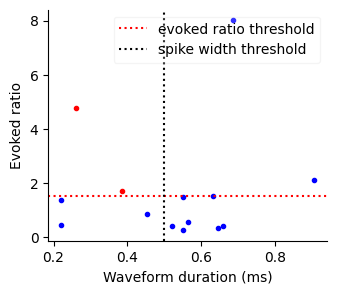

In [16]:
optotag_df, positive_units = detect_optotag(optotag_df, evoked_ratio_threshold, spike_width_threshold)
n_units = positive_units.size

print(f"Number of positive units: {n_units:d}")

_, ax = plt.subplots(1, 1, figsize=figsize)
plot_optotag_units(optotag_df, evoked_ratio_threshold, spike_width_threshold, ax=ax)

plt.show()

## Plot PLV

In [17]:
plv_all = {}
plv_windows = {}
for stim, spike_phase in spike_phases.items():
    plv_all[stim] = phase_locking_value(spike_phase, unit_ids=positive_units, presentation_ids=None, unbiased=True)
    if spike_phase.window.size > 1:
        plv_windows[stim] = {}
        for win in spike_phase.window.values:
            presentation_ids = spike_phase.presentation_ids.sel(window=win)
            plv_windows[stim][win] = phase_locking_value(spike_phase,
                unit_ids=positive_units, presentation_ids=presentation_ids.values, unbiased=True)

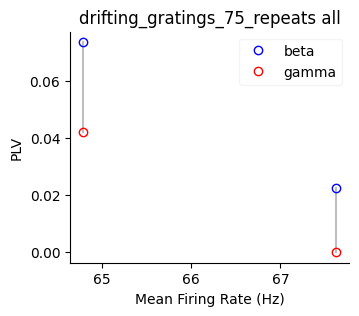

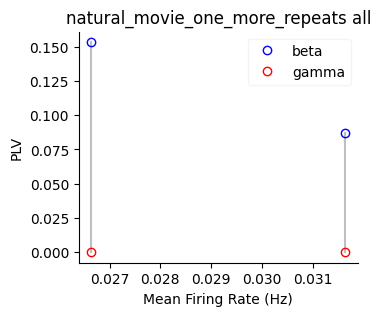

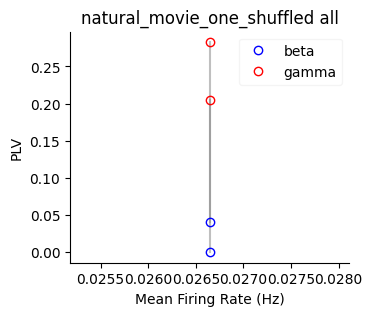

In [18]:
for stim, plv in plv_all.items():
    plv_waves = []
    for w in waves:
        p = plv.sel(wave=w)
        plv_waves.append([p.mean_firing_rate, p.PLV_unbiased])
    plv_waves = np.array(plv_waves)  # (wave, xy, units)

    _, ax = plt.subplots(1, 1, figsize=figsize)
    for cu in plv_waves.swapaxes(0, -1):  # (units, xy, wave)
        ax.plot(*cu, color='gray', alpha=0.5)  # connect same unit
    for i, w in enumerate(waves):
        ax.plot(*plv_waves[i], 'o', color=colors[w],
                markerfacecolor='none', label=w)
    ax.set_xlabel("Mean Firing Rate (Hz)")
    ax.set_ylabel("PLV")
    ax.set_title(f'{stim:s} all')
    ax.legend(loc='upper right', framealpha=0.2)
    plt.show()

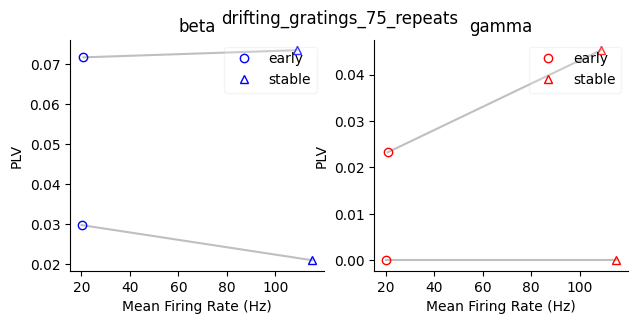

In [19]:
win_markers = ['o', '^']

for stim, plv_win in plv_windows.items():
    plv_wins = []
    for win, plv in plv_win.items():
        plv_waves = []
        for w in waves:
            p = plv.sel(wave=w)
            plv_waves.append([p.mean_firing_rate, p.PLV_unbiased])
        plv_wins.append(plv_waves)
    plv_wins = np.array(plv_wins).swapaxes(0, 1)  # (wave, windows, xy, units)

    fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for i, w in enumerate(waves):
        ax = axs[i]
        for cu in plv_wins[i].swapaxes(0, -1):  # (units, xy, windows)
            ax.plot(*cu, color='gray', alpha=0.5)  # connect same unit
        for j, win in enumerate(plv_win):
            ax.plot(*plv_wins[i, j], linestyle='none', marker=win_markers[j],
                    color=colors[w], markerfacecolor='none', label=f'{win:s}')
        ax.set_xlabel("Mean Firing Rate (Hz)")
        ax.set_ylabel("PLV")
        ax.set_title(w)
        ax.legend(loc='upper right', framealpha=0.2)
    fig.suptitle(stim)
    plt.show()

### List average PLV

In [20]:
stim_windows = []
variables = ['mean firing rate'] + ['PLV ' + w for w in waves]
plv_df = {v: [] for v in variables}
for stim, plv in plv_all.items():
    plvs = []
    stim_windows.append(f'{stim:s} all')
    plvs.append(plv)
    if stim in plv_windows:
        for win, plv in plv_windows[stim].items():
            stim_windows.append(f'{stim:s} {win:s}')
            plvs.append(plv)
    for plv in plvs:
        plv_df['mean firing rate'].append(plv.mean_firing_rate.mean().item())
        for w in waves:
            plv_df['PLV ' + w].append(plv.sel(wave=w).PLV_unbiased.mean().item())

plv_df = pd.DataFrame(plv_df, index=stim_windows)
plv_df.index.name = 'stimulus duration'

with pd.option_context('display.float_format', '{:.3f}'.format):
    print(plv_df)

                                     mean firing rate  PLV beta  PLV gamma
stimulus duration                                                         
drifting_gratings_75_repeats all               66.207     0.048      0.021
drifting_gratings_75_repeats early             20.425     0.051      0.012
drifting_gratings_75_repeats stable           111.989     0.047      0.023
natural_movie_one_more_repeats all              0.029     0.120      0.000
natural_movie_one_shuffled all                  0.027     0.020      0.244


In [21]:
# Save results table
plv_file = os.path.join(probe_dir, f'{ecephys_structure_acronym:s}_opto_tagged_plv.csv')
plv_df.to_csv(plv_file)